In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

In [3]:
def maxpool3d(x):
    #                        size of window         movement of window
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [4]:
def train_neural_network(x):
    
    with tf.Session() as sess:
        meta_path = '/home/lvruyi/noxrot_small_epoch_520/regression_small_epoch_520.meta'
        checkpoint_path = '/home/lvruyi/noxrot_small_epoch_520'
        saver1 = tf.train.import_meta_graph(meta_path)
        #saver1= tf.train.Saver(tf.global_variables())
        #saver1= tf.train.Saver(tf.local_variables())
        saver1.restore(sess, tf.train.latest_checkpoint(checkpoint_path))
        #tf.reset_default_graph()
        
        graph = tf.get_default_graph()
        
        x = graph.get_tensor_by_name("x:0")
        y = graph.get_tensor_by_name("y:0")
        cost = graph.get_tensor_by_name("cost:0")

        
        prediction = graph.get_tensor_by_name("output:0")
        
        
        """
        #for removing dropout
        weights = {'W_conv1':graph.get_tensor_by_name("W_conv1:0"),
               'W_conv2':graph.get_tensor_by_name("W_conv2:0"),
               'W_conv3':graph.get_tensor_by_name("W_conv3:0"),
               'W_conv4':graph.get_tensor_by_name("W_conv4:0"),
               'W_conv5':graph.get_tensor_by_name("W_conv5:0"),
               'W_fc':graph.get_tensor_by_name("W_fc:0"),
               'W_out':graph.get_tensor_by_name("W_out:0")}

        biases = {'b_conv1':graph.get_tensor_by_name("b_conv1:0"),
               'b_conv2':graph.get_tensor_by_name("b_conv2:0"),
              'b_conv3':graph.get_tensor_by_name("b_conv3:0"),
              'b_conv4':graph.get_tensor_by_name("b_conv4:0"),
              'b_conv5':graph.get_tensor_by_name("b_conv5:0"),
               'b_fc':graph.get_tensor_by_name("b_fc:0"),
               'b_out':graph.get_tensor_by_name("b_out:0")}
        
        
        conv1 = tf.nn.relu(conv3d(tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1]), 
        weights['W_conv1']) + biases['b_conv1'])
        conv1 = maxpool3d(conv1)

        conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
        conv2 = maxpool3d(conv2)

        conv3 = tf.nn.relu(conv3d(conv2, weights['W_conv3']) + biases['b_conv3'])
        conv3 = maxpool3d(conv3)

        conv4 = tf.nn.relu(conv3d(conv3, weights['W_conv4']) + biases['b_conv4'])
        conv4 = maxpool3d(conv4)

        conv5 = tf.nn.relu(conv3d(conv4, weights['W_conv5']) + biases['b_conv5'])
        conv5 = maxpool3d(conv5)


        fc = tf.reshape(conv5,[-1, 2304])
        fc = tf.matmul(fc, weights['W_fc'])+biases['b_fc']

        prediction = tf.add(tf.matmul(fc, weights['W_out']),biases['b_out'],name="output")
        cost = tf.reduce_mean(tf.square(prediction-y),name="cost")
        """
        
        Y = []
        X = []
        ii = 1
        for current_batch in range (0, train_batch):
                batch_data = np.load(folder + 'batch({},{})-{}-{}-{}.npy'.format(current_batch*batch_size+1,
                                    current_batch*batch_size+batch_size,IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT))
                data_i = current_batch*batch_size+1
                for data in batch_data:
                    predict_value = sess.run(prediction, feed_dict={x:[data[0]], y:[data[1]]})[0][0]
                    label_value = data[1][0]
                    selected = labels_file[labels_file.shuffledID == data_i]
                    for index, row in selected.iterrows():
                        cohort = row['COHORT']
                    if predict_value>0 and predict_value<100:
                        Y.append(predict_value)
                        X.append(label_value)
                        print (ii, "-----label value:", label_value, ";    estimated value:", predict_value)
                        ii = ii +1
                    data_i = data_i +1

        
        plt.title('Train Data')
        plt.xlabel('label')
        plt.ylabel('estimated')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        for index in range(len(X)):
            plt.scatter(X[index], Y[index], c = 'blue', s=1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        
        avg_cost = 0.
        pred_matrix = np.array([]).reshape(0,1)
        label_matrix = np.array([]).reshape(0,1)
        for current_batch in range (0, train_batch):
            batch_data = np.load(folder + 'batch({},{})-{}-{}-{}.npy'.format(current_batch*batch_size+1,
                                    current_batch*batch_size+batch_size,IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT))
            data_i = current_batch*batch_size+1
            for data in batch_data:
                    c, predict_value = sess.run([cost, prediction], feed_dict={x:data[0], y:data[1]})
                    predict_value=predict_value.reshape(1,1)
                    label_value = data[1].reshape(1,1)
                    selected = labels_file[labels_file.shuffledID == data_i]
                    for index, row in selected.iterrows():
                        cohort = row['COHORT']
                    if predict_value>0 and predict_value<100 and cohort!='IXI':
                        avg_cost += c / (train_batch * batch_size)
                        pred_matrix=np.concatenate((pred_matrix, predict_value), axis=0)
                        label_matrix=np.concatenate((label_matrix, label_value), axis=0)
                        print ("label value:", label_value, ";    estimated value:", predict_value, "avgcost", avg_cost)
                    data_i = data_i +1
            
            pred_matrix=np.concatenate((pred_matrix, predict_value), axis=0)
            label_matrix=np.concatenate((label_matrix, label_value), axis=0)

        print(np.concatenate((pred_matrix.T, label_matrix.T),axis=0).shape)
        evaluated_accuracy = np.corrcoef(np.concatenate((pred_matrix.T, label_matrix.T), axis=0))
        print('pearson:',evaluated_accuracy)
        
        Y = []
        X = []
        for current_validation in range (train_batch, train_batch+validation_batch):
                validation_data = np.load(folder + 'batch({},{})-{}-{}-{}.npy'.format(current_validation*batch_size+1,
                                    current_validation*batch_size+batch_size,IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT))
                data_i = current_validation*batch_size+1
                for data in validation_data:
                    predict_value = sess.run(prediction, feed_dict={x:data[0], y:data[1]})[0][0]
                    label_value = data[1][0]
                    selected = labels_file[labels_file.shuffledID == data_i]
                    for index, row in selected.iterrows():
                        cohort = row['COHORT']
                    if predict_value>0 and predict_value<100:
                        Y.append(predict_value)
                        X.append(label_value)
                        print ("label value:", label_value, ";    estimated value:", predict_value)
                    data_i = data_i +1

        plt.title('Test Data')
        plt.xlabel('Chronological Age')
        plt.ylabel('Brain Age')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        for ii in range(len(X)):
            plt.scatter(X[ii], Y[ii], c = 'blue',s=1)
        plt.gca().set_aspect('equal', adjustable='box')
        #plt.draw()
        
        
        
        avg_cost = 0.
        pred_matrix = np.array([]).reshape(0,1)
        label_matrix = np.array([]).reshape(0,1)
        for current_validation in range (train_batch, train_batch+validation_batch):
            validation_data = np.load(folder + 'batch({},{})-{}-{}-{}.npy'.format(current_validation*batch_size+1,
                                                current_validation*batch_size+batch_size,IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT))
            data_i = current_validation*batch_size+1
            for data in validation_data:
                    c, predict_value = sess.run([cost, prediction], feed_dict={x:data[0], y:data[1]})
                    predict_value=predict_value.reshape(1,1)
                    label_value = data[1].reshape(1,1)
                    selected = labels_file[labels_file.shuffledID == data_i]
                    for index, row in selected.iterrows():
                        cohort = row['COHORT']
                    if predict_value>0 and predict_value<100 and cohort!='IXI':
                        avg_cost += c / (validation_batch * batch_size)
                        pred_matrix=np.concatenate((pred_matrix, predict_value), axis=0)
                        label_matrix=np.concatenate((label_matrix, label_value), axis=0)
                        print ("label value:", label_value, ";    estimated value:", predict_value, "avgcost", avg_cost)
                    data_i = data_i +1
            
            pred_matrix=np.concatenate((pred_matrix, predict_value), axis=0)
            label_matrix=np.concatenate((label_matrix, label_value), axis=0)

        print(np.concatenate((pred_matrix.T, label_matrix.T),axis=0).shape)
        evaluated_accuracy = np.corrcoef(np.concatenate((pred_matrix.T, label_matrix.T), axis=0))
        print('pearson:',evaluated_accuracy)
        """
        """

INFO:tensorflow:Restoring parameters from /home/lvruyi/noxrot_small_epoch_520/regression_small_epoch_520
1 -----label value: 9 ;    estimated value: 12.584121
2 -----label value: 10 ;    estimated value: 10.66206
3 -----label value: 9 ;    estimated value: 13.04045
4 -----label value: 16 ;    estimated value: 24.279507
5 -----label value: 82 ;    estimated value: 68.14004
6 -----label value: 23 ;    estimated value: 15.655199
7 -----label value: 14 ;    estimated value: 14.061595
8 -----label value: 20 ;    estimated value: 48.191875
9 -----label value: 11 ;    estimated value: 13.596959
10 -----label value: 70 ;    estimated value: 63.052017
11 -----label value: 83 ;    estimated value: 19.174093
12 -----label value: 11 ;    estimated value: 9.993084
13 -----label value: 24 ;    estimated value: 21.874187
14 -----label value: 21 ;    estimated value: 24.008753
15 -----label value: 18 ;    estimated value: 13.133951
16 -----label value: 8 ;    estimated value: 8.450456
17 -----label va

177 -----label value: 24 ;    estimated value: 20.109634
178 -----label value: 9 ;    estimated value: 13.26552
179 -----label value: 9 ;    estimated value: 12.251996
180 -----label value: 83 ;    estimated value: 79.3101
181 -----label value: 22 ;    estimated value: 20.848883
182 -----label value: 13 ;    estimated value: 14.417451
183 -----label value: 14 ;    estimated value: 13.009189
184 -----label value: 15 ;    estimated value: 25.551792
185 -----label value: 25 ;    estimated value: 13.659158
186 -----label value: 43 ;    estimated value: 32.705364
187 -----label value: 17 ;    estimated value: 12.481553
188 -----label value: 27 ;    estimated value: 37.546516
189 -----label value: 22 ;    estimated value: 20.970554
190 -----label value: 41 ;    estimated value: 27.40203
191 -----label value: 9 ;    estimated value: 13.875404
192 -----label value: 18 ;    estimated value: 10.082679
193 -----label value: 26 ;    estimated value: 16.786678
194 -----label value: 11 ;    estimate

335 -----label value: 28 ;    estimated value: 17.313427
336 -----label value: 22 ;    estimated value: 12.425853
337 -----label value: 39 ;    estimated value: 22.803713
338 -----label value: 10 ;    estimated value: 10.327621
339 -----label value: 9 ;    estimated value: 14.477563
340 -----label value: 9 ;    estimated value: 11.770853
341 -----label value: 16 ;    estimated value: 17.964073
342 -----label value: 25 ;    estimated value: 22.546768
343 -----label value: 9 ;    estimated value: 12.80081
344 -----label value: 69 ;    estimated value: 74.01192
345 -----label value: 9 ;    estimated value: 10.293572
346 -----label value: 13 ;    estimated value: 11.164725
347 -----label value: 54 ;    estimated value: 26.591501
348 -----label value: 69 ;    estimated value: 52.51567
349 -----label value: 18 ;    estimated value: 18.964842
350 -----label value: 10 ;    estimated value: 13.806613
351 -----label value: 11 ;    estimated value: 11.262999
352 -----label value: 26 ;    estimate

497 -----label value: 11 ;    estimated value: 12.612722
498 -----label value: 9 ;    estimated value: 10.52429
499 -----label value: 22 ;    estimated value: 15.157863
500 -----label value: 19 ;    estimated value: 16.445711
501 -----label value: 75 ;    estimated value: 44.14295
502 -----label value: 9 ;    estimated value: 14.234083
503 -----label value: 8 ;    estimated value: 13.95437
504 -----label value: 8 ;    estimated value: 11.2841215
505 -----label value: 86 ;    estimated value: 97.37998
506 -----label value: 22 ;    estimated value: 22.401905
507 -----label value: 16 ;    estimated value: 16.753788
508 -----label value: 12 ;    estimated value: 10.758992
509 -----label value: 9 ;    estimated value: 10.673845
510 -----label value: 80 ;    estimated value: 86.47534
511 -----label value: 66 ;    estimated value: 56.50094
512 -----label value: 22 ;    estimated value: 22.261312
513 -----label value: 59 ;    estimated value: 63.126247
514 -----label value: 73 ;    estimated v

673 -----label value: 73 ;    estimated value: 70.847534
674 -----label value: 11 ;    estimated value: 12.265419
675 -----label value: 30 ;    estimated value: 16.005962
676 -----label value: 17 ;    estimated value: 16.88699
677 -----label value: 14 ;    estimated value: 10.669051
678 -----label value: 9 ;    estimated value: 12.999373
679 -----label value: 23 ;    estimated value: 14.163356
680 -----label value: 17 ;    estimated value: 18.432598
681 -----label value: 10 ;    estimated value: 13.226314
682 -----label value: 70 ;    estimated value: 58.55854
683 -----label value: 48 ;    estimated value: 55.998398
684 -----label value: 65 ;    estimated value: 51.125053
685 -----label value: 19 ;    estimated value: 21.022
686 -----label value: 74 ;    estimated value: 77.001144
687 -----label value: 21 ;    estimated value: 26.21604
688 -----label value: 43 ;    estimated value: 55.185135
689 -----label value: 11 ;    estimated value: 12.306836
690 -----label value: 12 ;    estimate

848 -----label value: 9 ;    estimated value: 10.252401
849 -----label value: 10 ;    estimated value: 10.514357
850 -----label value: 16 ;    estimated value: 17.576176
851 -----label value: 10 ;    estimated value: 10.774392
852 -----label value: 90 ;    estimated value: 81.265274
853 -----label value: 27 ;    estimated value: 19.511457
854 -----label value: 12 ;    estimated value: 14.138743
855 -----label value: 58 ;    estimated value: 64.113976
856 -----label value: 12 ;    estimated value: 14.213029
857 -----label value: 23 ;    estimated value: 16.71452
858 -----label value: 72 ;    estimated value: 69.59595
859 -----label value: 81 ;    estimated value: 69.06617
860 -----label value: 26 ;    estimated value: 21.794075
861 -----label value: 36 ;    estimated value: 44.114754
862 -----label value: 12 ;    estimated value: 10.347724
863 -----label value: 73 ;    estimated value: 79.292076
864 -----label value: 10 ;    estimated value: 10.71342
865 -----label value: 71 ;    estima

1009 -----label value: 86 ;    estimated value: 81.49923
1010 -----label value: 15 ;    estimated value: 15.815911
1011 -----label value: 10 ;    estimated value: 11.47412
1012 -----label value: 22 ;    estimated value: 16.96451
1013 -----label value: 20 ;    estimated value: 16.319778
1014 -----label value: 19 ;    estimated value: 13.253809
1015 -----label value: 11 ;    estimated value: 10.038482
1016 -----label value: 9 ;    estimated value: 10.310437
1017 -----label value: 28 ;    estimated value: 23.10223
1018 -----label value: 10 ;    estimated value: 10.023548
1019 -----label value: 13 ;    estimated value: 10.337153
1020 -----label value: 18 ;    estimated value: 15.881808
1021 -----label value: 9 ;    estimated value: 13.251779
1022 -----label value: 26 ;    estimated value: 32.505463
1023 -----label value: 11 ;    estimated value: 9.576753
1024 -----label value: 11 ;    estimated value: 14.064635
1025 -----label value: 21 ;    estimated value: 34.613773
1026 -----label value

1167 -----label value: 33 ;    estimated value: 15.8236475
1168 -----label value: 11 ;    estimated value: 12.66143
1169 -----label value: 9 ;    estimated value: 11.885261
1170 -----label value: 17 ;    estimated value: 20.116652
1171 -----label value: 16 ;    estimated value: 16.63789
1172 -----label value: 68 ;    estimated value: 56.227825
1173 -----label value: 10 ;    estimated value: 14.300248
1174 -----label value: 14 ;    estimated value: 11.112522
1175 -----label value: 22 ;    estimated value: 15.86938
1176 -----label value: 10 ;    estimated value: 11.451148
1177 -----label value: 12 ;    estimated value: 10.505963
1178 -----label value: 9 ;    estimated value: 10.378477
1179 -----label value: 90 ;    estimated value: 63.78337
1180 -----label value: 23 ;    estimated value: 13.085974
1181 -----label value: 43 ;    estimated value: 12.349391
1182 -----label value: 21 ;    estimated value: 24.955347
1183 -----label value: 26 ;    estimated value: 18.70508
1184 -----label valu

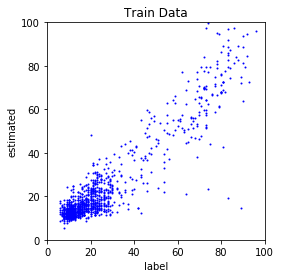

label value: [[9]] ;    estimated value: [[11.034094]] avgcost 0.0034479482968648276
label value: [[10]] ;    estimated value: [[11.332388]] avgcost 0.0049273296197255454
label value: [[9]] ;    estimated value: [[10.097304]] avgcost 0.005930726925532023
label value: [[16]] ;    estimated value: [[21.543028]] avgcost 0.03153502583503723
label value: [[82]] ;    estimated value: [[47.289295]] avgcost 1.035562532345454
label value: [[23]] ;    estimated value: [[16.149557]] avgcost 1.0746696706612906
label value: [[14]] ;    estimated value: [[14.647145]] avgcost 1.0750186681747438
label value: [[20]] ;    estimated value: [[42.545338]] avgcost 1.4985955317815147
label value: [[11]] ;    estimated value: [[12.888433]] avgcost 1.501567349235217
label value: [[70]] ;    estimated value: [[55.98005]] avgcost 1.6653665333986285
label value: [[83]] ;    estimated value: [[17.615284]] avgcost 5.2280012176434205
label value: [[11]] ;    estimated value: [[10.0081415]] avgcost 5.228821037014326


label value: [[11]] ;    estimated value: [[10.554031]] avgcost 11.550108265538661
label value: [[12]] ;    estimated value: [[11.9154215]] avgcost 11.550114226809509
label value: [[12]] ;    estimated value: [[12.90136]] avgcost 11.550791267674533
label value: [[62]] ;    estimated value: [[42.06456]] avgcost 11.881976087213921
label value: [[16]] ;    estimated value: [[13.141896]] avgcost 11.88878338507947
label value: [[61]] ;    estimated value: [[45.92036]] avgcost 12.078279654305545
label value: [[52]] ;    estimated value: [[46.08296]] avgcost 12.107455806852746
label value: [[20]] ;    estimated value: [[17.614761]] avgcost 12.112196943085758
label value: [[83]] ;    estimated value: [[63.233135]] avgcost 12.437804395478336
label value: [[27]] ;    estimated value: [[16.433603]] avgcost 12.53084501437482
label value: [[7]] ;    estimated value: [[16.660137]] avgcost 12.608610224844384
label value: [[21]] ;    estimated value: [[12.156364]] avgcost 12.67378513507184
label value

label value: [[81]] ;    estimated value: [[33.44942]] avgcost 18.502569123399322
label value: [[14]] ;    estimated value: [[13.092819]] avgcost 18.503254937571352
label value: [[58]] ;    estimated value: [[43.07314]] avgcost 18.68893091464248
label value: [[9]] ;    estimated value: [[13.88921]] avgcost 18.708851224027143
label value: [[11]] ;    estimated value: [[13.759004]] avgcost 18.71519464159217
label value: [[8]] ;    estimated value: [[7.675046]] avgcost 18.715282637531125
label value: [[10]] ;    estimated value: [[13.093152]] avgcost 18.72325562899765
label value: [[12]] ;    estimated value: [[13.512135]] avgcost 18.725161088163222
label value: [[34]] ;    estimated value: [[22.7672]] avgcost 18.83030757889605
label value: [[12]] ;    estimated value: [[12.541141]] avgcost 18.83055160647091
label value: [[48]] ;    estimated value: [[38.732986]] avgcost 18.902116223627893
label value: [[10]] ;    estimated value: [[10.40874]] avgcost 18.90225544731276
label value: [[15]]

label value: [[92]] ;    estimated value: [[80.10962]] avgcost 24.301970442356435
label value: [[11]] ;    estimated value: [[12.555718]] avgcost 24.30398732545154
label value: [[11]] ;    estimated value: [[18.640875]] avgcost 24.35263979953703
label value: [[12]] ;    estimated value: [[10.418803]] avgcost 24.354723285656938
label value: [[16]] ;    estimated value: [[16.833803]] avgcost 24.355302642108768
label value: [[22]] ;    estimated value: [[19.824755]] avgcost 24.359245718639862
label value: [[18]] ;    estimated value: [[24.253551]] avgcost 24.391834807715586
label value: [[25]] ;    estimated value: [[16.144588]] avgcost 24.457183401109546
label value: [[13]] ;    estimated value: [[15.624628]] avgcost 24.462923961402744
label value: [[12]] ;    estimated value: [[11.142249]] avgcost 24.463537075243163
label value: [[6]] ;    estimated value: [[12.976996]] avgcost 24.5041024737773
label value: [[9]] ;    estimated value: [[10.249774]] avgcost 24.50540408623394
label value:

label value: [[11]] ;    estimated value: [[12.563261]] avgcost 33.21650583028161
label value: [[9]] ;    estimated value: [[11.221482]] avgcost 33.220618316723545
label value: [[22]] ;    estimated value: [[15.103104]] avgcost 33.260257633918165
label value: [[19]] ;    estimated value: [[16.851309]] avgcost 33.26410502870246
label value: [[75]] ;    estimated value: [[50.280582]] avgcost 33.773313046687484
label value: [[9]] ;    estimated value: [[12.067897]] avgcost 33.7811563726203
label value: [[8]] ;    estimated value: [[13.615037]] avgcost 33.80743023990953
label value: [[8]] ;    estimated value: [[16.504162]] avgcost 33.86769754846259
label value: [[86]] ;    estimated value: [[87.760124]] avgcost 33.870279246165
label value: [[22]] ;    estimated value: [[19.002384]] avgcost 33.87776733000442
label value: [[16]] ;    estimated value: [[19.605606]] avgcost 33.88860099235539
label value: [[12]] ;    estimated value: [[10.5937195]] avgcost 33.89024901309972
label value: [[9]] 

label value: [[33]] ;    estimated value: [[20.041464]] avgcost 37.5903863816781
label value: [[72]] ;    estimated value: [[56.721146]] avgcost 37.784922539921915
label value: [[46]] ;    estimated value: [[58.10301]] avgcost 37.906991542709186
label value: [[19]] ;    estimated value: [[19.12506]] avgcost 37.907004575863915
label value: [[11]] ;    estimated value: [[8.862856]] avgcost 37.91081072979712
label value: [[21]] ;    estimated value: [[22.451452]] avgcost 37.91256632440829
label value: [[11]] ;    estimated value: [[14.024141]] avgcost 37.92018751654569
label value: [[8]] ;    estimated value: [[12.838972]] avgcost 37.93970055931353
label value: [[9]] ;    estimated value: [[10.75977]] avgcost 37.94228121910039
label value: [[76]] ;    estimated value: [[50.686157]] avgcost 38.47627342694544
label value: [[11]] ;    estimated value: [[10.699487]] avgcost 38.47634868380098
label value: [[13]] ;    estimated value: [[16.941381]] avgcost 38.4892940902379
label value: [[13]] ;

label value: [[18]] ;    estimated value: [[17.551086]] avgcost 45.13823967553713
label value: [[14]] ;    estimated value: [[14.982841]] avgcost 45.13904465513963
label value: [[13]] ;    estimated value: [[13.5833645]] avgcost 45.13932825023967
label value: [[8]] ;    estimated value: [[5.4539137]] avgcost 45.144730379730845
label value: [[34]] ;    estimated value: [[37.76506]] avgcost 45.15654344653128
label value: [[75]] ;    estimated value: [[61.379627]] avgcost 45.31113891060192
label value: [[24]] ;    estimated value: [[15.440894]] avgcost 45.37218748822846
label value: [[11]] ;    estimated value: [[10.727187]] avgcost 45.37224951059906
label value: [[13]] ;    estimated value: [[12.523861]] avgcost 45.37243843427587
label value: [[25]] ;    estimated value: [[20.58355]] avgcost 45.38869263044286
label value: [[55]] ;    estimated value: [[47.953587]] avgcost 45.43006924978185
label value: [[29]] ;    estimated value: [[28.744215]] avgcost 45.43012377141703
label value: [[62

label value: [[9]] ;    estimated value: [[15.744134]] avgcost 49.967579046888666
label value: [[9]] ;    estimated value: [[9.090028]] avgcost 49.96758580106039
label value: [[10]] ;    estimated value: [[14.776972]] avgcost 49.98660201765635
label value: [[9]] ;    estimated value: [[13.973194]] avgcost 50.007212567901
label value: [[11]] ;    estimated value: [[10.311234]] avgcost 50.007607899532104
label value: [[35]] ;    estimated value: [[16.600195]] avgcost 50.289735254471886
label value: [[72]] ;    estimated value: [[57.641163]] avgcost 50.46154876155197
label value: [[25]] ;    estimated value: [[27.085016]] avgcost 50.46517150563537
label value: [[12]] ;    estimated value: [[10.779053]] avgcost 50.46641376577356
label value: [[19]] ;    estimated value: [[11.9260845]] avgcost 50.50811399859725
label value: [[22]] ;    estimated value: [[12.433437]] avgcost 50.584379931316164
label value: [[10]] ;    estimated value: [[14.158968]] avgcost 50.59879410984654
label value: [[20

label value: [[51]] ;    estimated value: [[30.763245]] avgcost 53.921164818734304
label value: [[59]] ;    estimated value: [[49.96463]] avgcost 53.98919640951393
label value: [[22]] ;    estimated value: [[27.80559]] avgcost 54.01728380295672
label value: [[9]] ;    estimated value: [[14.9287615]] avgcost 54.046575645735246
label value: [[27]] ;    estimated value: [[29.500118]] avgcost 54.05178447180031
label value: [[16]] ;    estimated value: [[14.596875]] avgcost 54.05342510444957
label value: [[9]] ;    estimated value: [[12.346768]] avgcost 54.0627591528797
label value: [[28]] ;    estimated value: [[34.174538]] avgcost 54.09452991627692
label value: [[80]] ;    estimated value: [[64.54724]] avgcost 54.29351970814704
label value: [[14]] ;    estimated value: [[11.259228]] avgcost 54.2997795687421
label value: [[22]] ;    estimated value: [[16.770926]] avgcost 54.322565585206334
label value: [[11]] ;    estimated value: [[19.396519]] avgcost 54.38131685677209
label value: [[9]] 

label value: [[20]] ;    estimated value: [[16.446264]] avgcost 60.06590155077194
label value: [[22]] ;    estimated value: [[31.424398]] avgcost 60.13991761954839
label value: [[10]] ;    estimated value: [[10.4713745]] avgcost 60.14010278115387
label value: [[23]] ;    estimated value: [[29.216091]] avgcost 60.17230260580495
label value: [[10]] ;    estimated value: [[12.879591]] avgcost 60.179212643004604
label value: [[19]] ;    estimated value: [[31.206894]] avgcost 60.303386188842005
label value: [[9]] ;    estimated value: [[11.468222]] avgcost 60.308462954061376
label value: [[12]] ;    estimated value: [[12.685884]] avgcost 60.30885498533363
label value: [[22]] ;    estimated value: [[22.54933]] avgcost 60.30910645464773
label value: [[12]] ;    estimated value: [[17.008505]] avgcost 60.33001072227672
label value: [[12]] ;    estimated value: [[12.7458725]] avgcost 60.33047432710444
label value: [[10]] ;    estimated value: [[11.427909]] avgcost 60.33217343022143
label value: 

label value: [[11]] ;    estimated value: [[12.1495905]] avgcost 64.98442946957819
label value: [[9]] ;    estimated value: [[14.15237]] avgcost 65.00655190355849
label value: [[17]] ;    estimated value: [[14.753112]] avgcost 65.01075899210842
label value: [[16]] ;    estimated value: [[14.948359]] avgcost 65.011680616908
label value: [[68]] ;    estimated value: [[43.005775]] avgcost 65.53227331913781
label value: [[10]] ;    estimated value: [[13.836989]] avgcost 65.54454205867918
label value: [[14]] ;    estimated value: [[10.0426035]] avgcost 65.55759288109613
label value: [[22]] ;    estimated value: [[25.47072]] avgcost 65.56763113058878
label value: [[10]] ;    estimated value: [[10.349608]] avgcost 65.5677329856321
label value: [[12]] ;    estimated value: [[10.441217]] avgcost 65.56975782157627
label value: [[9]] ;    estimated value: [[10.468686]] avgcost 65.5715553540155
label value: [[90]] ;    estimated value: [[89.31317]] avgcost 65.57194846529909
label value: [[23]] ;  

label value: 17 ;    estimated value: 28.300457
label value: 27 ;    estimated value: 23.433811
label value: 10 ;    estimated value: 13.457929
label value: 10 ;    estimated value: 10.284284
label value: 44 ;    estimated value: 30.999907
label value: 9 ;    estimated value: 13.705966
label value: 34 ;    estimated value: 17.555
label value: 19 ;    estimated value: 14.265656
label value: 10 ;    estimated value: 12.473901
label value: 86 ;    estimated value: 34.759823
label value: 10 ;    estimated value: 10.450481
label value: 10 ;    estimated value: 10.412971
label value: 13 ;    estimated value: 15.940797
label value: 19 ;    estimated value: 31.863815
label value: 23 ;    estimated value: 14.892942
label value: 14 ;    estimated value: 15.751303
label value: 19 ;    estimated value: 11.913939
label value: 25 ;    estimated value: 25.484047
label value: 24 ;    estimated value: 49.804657
label value: 15 ;    estimated value: 26.373178
label value: 27 ;    estimated value: 10.672

label value: [[12]] ;    estimated value: [[10.591872]] avgcost 7.136851571697836
label value: [[86]] ;    estimated value: [[60.160896]] avgcost 9.591481357572146
label value: [[39]] ;    estimated value: [[23.591274]] avgcost 10.464381478924398
label value: [[78]] ;    estimated value: [[32.453403]] avgcost 18.091191889367874
label value: [[15]] ;    estimated value: [[13.040053]] avgcost 18.10531464983905
label value: [[12]] ;    estimated value: [[11.430045]] avgcost 18.106508946024633
label value: [[22]] ;    estimated value: [[38.952168]] avgcost 19.16303827162206
label value: [[62]] ;    estimated value: [[37.34452]] avgcost 21.397937680299105
label value: [[25]] ;    estimated value: [[14.717874]] avgcost 21.786621953065218
label value: [[71]] ;    estimated value: [[39.209972]] avgcost 25.502084581598076
label value: [[73]] ;    estimated value: [[56.67591]] avgcost 26.481775357749846
label value: [[13]] ;    estimated value: [[10.408739]] avgcost 26.506461508440935
label valu

label value: [[11]] ;    estimated value: [[15.896238]] avgcost 90.95740124260516
label value: [[22]] ;    estimated value: [[13.519811]] avgcost 91.2217895233615
label value: [[33]] ;    estimated value: [[36.97625]] avgcost 91.27991658652368
label value: [[58]] ;    estimated value: [[64.209496]] avgcost 91.42167333146944
label value: [[10]] ;    estimated value: [[10.833012]] avgcost 91.42422446526864
label value: [[43]] ;    estimated value: [[23.08775]] avgcost 92.88193663873055
label value: [[11]] ;    estimated value: [[14.451066]] avgcost 92.92572287695211
label value: [[12]] ;    estimated value: [[11.52969]] avgcost 92.92653608169245
label value: [[22]] ;    estimated value: [[40.95027]] avgcost 94.24680370290109
label value: [[21]] ;    estimated value: [[22.372444]] avgcost 94.2537287138452
label value: [[14]] ;    estimated value: [[15.882887]] avgcost 94.26676276918339
label value: [[16]] ;    estimated value: [[18.576153]] avgcost 94.29116189896679
label value: [[14]] ; 

label value: [[10]] ;    estimated value: [[10.5504465]] avgcost 168.18030273085543
label value: [[9]] ;    estimated value: [[13.217553]] avgcost 168.2456988854835
label value: [[10]] ;    estimated value: [[16.919474]] avgcost 168.42172504746273
label value: [[46]] ;    estimated value: [[14.434603]] avgcost 172.08486596148214
label value: [[14]] ;    estimated value: [[15.943407]] avgcost 172.09875136924552
label value: [[42]] ;    estimated value: [[18.000343]] avgcost 174.21633784170072
label value: [[8]] ;    estimated value: [[10.506112]] avgcost 174.23942827437267
label value: [[9]] ;    estimated value: [[10.6477995]] avgcost 174.24941078577385
label value: [[9]] ;    estimated value: [[13.468544]] avgcost 174.32282213125572
label value: [[11]] ;    estimated value: [[10.154506]] avgcost 174.32545029507378
label value: [[8]] ;    estimated value: [[16.600323]] avgcost 174.59738247626382
label value: [[11]] ;    estimated value: [[14.262288]] avgcost 174.6365094018725
label val

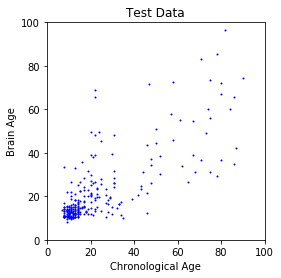

In [5]:
IMG_SIZE_PX = 65
SLICE_COUNT = 55
n_classes = 1
#train_batch = 15
train_batch = 75
#train_batch = 100
batch_size = 16
#validation_batch = 4
validation_batch = 17
#validation_batch = 29
labels_file = pd.read_csv('FYP_Phenotypic2noxrotate.csv')

x = tf.placeholder('float')
y = tf.placeholder('float')

learning_rate = 0.000001
dropout_rate = 1
epoch_save= 20
#"combined2\\"
folder = '/home/lvruyi/combined2noxrotate/'
hm_epochs = 20000

#calculate_mean()`

#shuffle()

"""
for batch in range (0, train_batch+validation_batch-1):
    combine_preprocess(batch*batch_size+1, batch*batch_size+batch_size)

combine_preprocess(2065, 2072)
"""
                                     
train_neural_network(x)
